In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver

from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.utils import *
from Problem.LogDataHandling import *
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "UK75_1"
meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}/{}.txt".format(dataset[:-2],dataset))

#station_coordinates = generate_coordinates(station_data, to_csv=True, filename=dataset)
location_context = "United Kingdom"
#station_coordinates = generate_coordinates(station_data,location_context,to_csv=True,filename=dataset)
station_coordinates = pd.read_csv('../datasets/{}/{}_coordinates.csv'.format(dataset[:-2],dataset), encoding='utf-8')
points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()

# #UK = gpd.read_file("../datasets/united_kingdom_european_regions/Regions__December_2019__Boundaries_EN_BFC-shp/Regions__December_2019__Boundaries_EN_BFC.shp")
dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
dbf = dbf.to_crs("EPSG:4326")
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000
# #distance_matrix_here,time_matrix_here,_ = generate_large_distance_matrix(points_coordinate,api)

distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/{}/".format(dataset[:-2]),dataset)

distance_matrix_here = distance_matrix_here.to_numpy()
time_matrix_here = time_matrix_here.to_numpy()

routingContext = RoutingContext(distance_matrix=distance_matrix_here,time_matrix=time_matrix_here,station_coordinates=station_coordinates,station_data=station_data,meta_data=meta_data)
startNodes = {"UK20_1":[0,6,10,15],"UK25":[0,6,10,15],"UK50":[0,6,10,15,21,35,40],"UK75":[0,6,10,15,21,35,40,60,31,68]}
endNodes = {"UK20_1":[4,20,2,5],"UK25":[4,20,2,5,22],"UK50":[4,20,2,5,32,45,1],"UK75":[4,20,2,5,32,45,1]}

mutation_arange = [np.round(x,2) for x in np.arange(0.1,1,0.2)]


startNodeIndeces = startNodes[dataset[:-2]]
endNodeIndeces = endNodes[dataset[:-2]]
locationNodeIndeces = list((set(range(len(points_coordinate))) - set(startNodeIndeces)) - set(endNodeIndeces))

vehicleData = {"emptyWeights":[3000,5500],"maxLoads":[3650,8500],"fuelEmpty":[12,22.5],"fuelFull":[15,27.5]}


vehicles = initializeVehicles(startIndices=startNodeIndeces,vehicleData=vehicleData,
                                                            routingContext=routingContext,heterogeneousFleet=True)

In [121]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import chain
def anova_plot2(data,variable_field,between_fields,path=None,save=False):
    fig,ax = plt.subplots(1,1,figsize=(15,15))
    tukey = pairwise_tukeyhsd(endog=data[variable_field],groups=data[between_fields],alpha=0.05)
    
    summary = tukey.summary()
    summary_as_html = summary.as_html()
    summary_df = pd.read_html(summary_as_html, header=0, index_col=0)[0]
    summary_df_rejects = summary_df.where(summary_df.reject == True)
    summary_df_rejects.dropna(inplace=True)
    
    best_parameter_group = summary_df.sort_values(by='meandiff').head(1).group2.values
    best_parameter_group = list(chain(*[best_parameter_group]))
    print(summary_df)
    summary_df["group1"] = summary_df.index
    
    
    non_rejected_non_optimal_groups = summary_df.where(summary_df.reject == False).dropna()
    non_rejected_non_optimal_groups2 = non_rejected_non_optimal_groups.where((summary_df.group1 == best_parameter_group*len(summary_df.group1)) | (summary_df.group2 == best_parameter_group*len(summary_df.group2))).dropna().unique()
    
    
    
    print(summary_df)
    non_rejected_non_optimal_parameter_groups = pd.DataFrame(columns=data.columns)
    for group in non_rejected_non_optimal_groups:
        non_rejected_non_optimal_parameter_groups = pd.concat([non_rejected_non_optimal_parameter_groups,(data.where(data["Parameter Group"] == np.float(group))).dropna()],axis=0)
    

    optimal_params = extractOptimalParameters2(data,summary_df_rejects,1)
    
    if len(optimal_params) > 0:
        
        optimal_group = int(optimal_params.head(1)[between_fields]) or None
    else:
        optimal_group = None
    tukey.plot_simultaneous(figsize=(15,15),ax=ax,comparison_name =optimal_group )
    ax.set_xlabel(variable_field,fontsize=24)
    ax.set_ylabel("Parameter Group",fontsize=24)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    plt.title("")
    plt.show()
    
    
    
    return summary_df_rejects ,fig, tukey
    
def anova_test(data,variable_field,between_fields):
    aov = pg.anova(dv=variable_field,between = between_fields,data=data,detailed=True)
    return aov
def extractOptimalParameters2(resultsDataFrame,tukeyResult,amount=5):
    optimalParamGroups = tukeyResult.sort_values(by='meandiff').head(amount).group2
    resultDF = pd.DataFrame(columns=resultsDataFrame.columns)
    for group in optimalParamGroups:
        resultDF = pd.concat([resultDF,(resultsDataFrame.where(resultsDataFrame["Parameter Group"] == np.float(group))).dropna()],axis=0)
    return resultDF


# SA

In [122]:
SA_25_2 = pd.read_csv("parameter_data/UK25_2/SA.csv")
SA_25_4 = pd.read_csv("parameter_data/UK25_4/SA.csv")
SA_25_8 = pd.read_csv("parameter_data/UK25_8/SA.csv")
SA_50_1 = pd.read_csv("parameter_data/UK50_1/SA.csv")
SA_50_2 = pd.read_csv("parameter_data/UK50_2/SA.csv")
SA_50_4 = pd.read_csv("parameter_data/UK50_4/SA.csv")
SA_75_1 = pd.read_csv("parameter_data/UK75_1/SA.csv")
SA_75_3 = pd.read_csv("parameter_data/UK75_3/SA.csv")
SA_75_6 = pd.read_csv("parameter_data/UK75_6/SA.csv")





SA_25_2 = remove_unwanted_mutation_parameter_groups(SA_25_2)
SA_25_2["Parameter Group"] = SA_25_2["Parameter Group"]/2
combined_SA = [SA_25_2,SA_25_4,SA_25_8,SA_50_1,SA_50_2,SA_50_4,SA_75_1,SA_75_3,SA_75_6]

for df in combined_SA:
    add_final_fitness_columns(df)
    expand_parameter_colums(df)
    add_distance_to_origin(df)
    
    max_fuel_consumption = max(df.fuel_consumption_final)
    min_fuel_consumption = min(df.fuel_consumption_final)
    df["fuel_consumption_final_minmax"] = (df.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption-min_fuel_consumption)
    
    max_distance_to_origin = max(df.distance_to_origin)
    min_distance_to_origin = min(df.distance_to_origin)
    df["distance_to_origin_minmax"] = (df.distance_to_origin - min_distance_to_origin)/(max_distance_to_origin-min_distance_to_origin)
    
    
SA_data = pd.concat(combined_SA)
    

In [123]:
datasetNames = ["UK25_2","UK25_4","UK25_8","UK50_1","UK75_1"]
optimal_params_SA=pd.DataFrame()
for dataframe,datasetName in zip(combined_SA,datasetNames):
    dataframe_optimal = dataframe.groupby(by=["Parameter Group"]).mean().sort_values(by=["distance_to_origin_minmax"]).head(1)
    dataframe_optimal["dataset"] = datasetName
    optimal_params_SA = pd.concat([optimal_params_SA,dataframe_optimal])
    
optimal_params_SA

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,distance_to_origin,fuel_consumption_final_minmax,distance_to_origin_minmax,dataset
Parameter Group,,,,,,,,
3.0,14.5,86.633271,140.506111,0.7,165.322624,0.306996,0.119296,UK25_2
3.0,14.5,244.868543,364.809444,0.7,439.445288,0.196697,0.094512,UK25_4
2.0,14.5,108.992845,233.645556,0.5,258.218305,0.203475,0.466620,UK25_8
4.0,14.5,226.218534,219.179444,0.9,315.201768,0.211321,0.147638,UK50_1
4.0,14.5,176.402670,233.542778,0.9,292.791280,0.184953,0.145488,UK75_1


        group2  meandiff   p-adj   lower   upper  reject
group1                                                  
0.0        1.0   -0.2106  0.0010 -0.2528 -0.1685    True
0.0        2.0   -0.2775  0.0010 -0.3196 -0.2353    True
0.0        3.0   -0.3165  0.0010 -0.3586 -0.2743    True
0.0        4.0   -0.3180  0.0010 -0.3602 -0.2759    True
1.0        2.0   -0.0669  0.0010 -0.1090 -0.0247    True
1.0        3.0   -0.1058  0.0010 -0.1480 -0.0637    True
1.0        4.0   -0.1074  0.0010 -0.1496 -0.0652    True
2.0        3.0   -0.0390  0.0860 -0.0811  0.0032   False
2.0        4.0   -0.0405  0.0665 -0.0827  0.0016   False
3.0        4.0   -0.0016  0.9000 -0.0437  0.0406   False


ValueError: cannot reindex from a duplicate axis

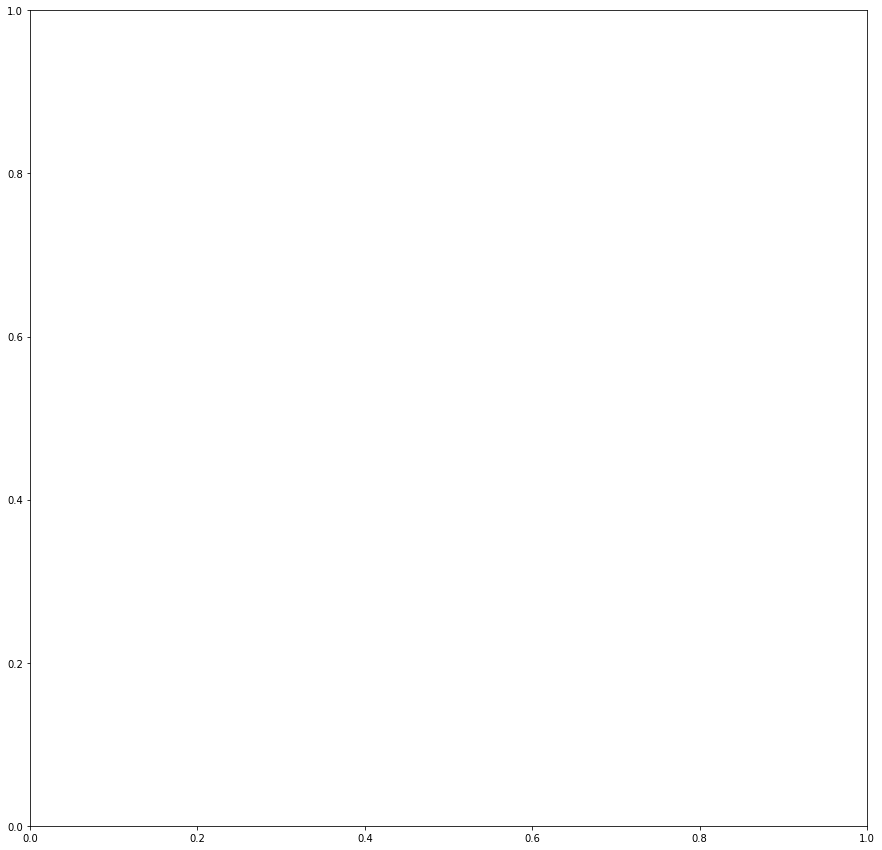

In [124]:
sa_data_tukey,fig,t = anova_plot2(SA_data,"distance_to_origin_minmax","Parameter Group")


# GA

In [154]:
GA_25_2 = pd.read_csv("parameter_data/UK25_2/GA.csv")
GA_25_4 = pd.read_csv("parameter_data/UK25_4/GA.csv")
GA_25_8 = pd.read_csv("parameter_data/UK25_8/GA.csv")
GA_50_1 = pd.read_csv("parameter_data/UK50_1/GA.csv")
GA_75_1 = pd.read_csv("parameter_data/UK75_1/GA.csv")





GA_25_2 = remove_unwanted_mutation_parameter_groups(GA_25_2)
GA_25_2["Parameter Group"] =sorted(list(range(45)) * 30)
combined_GA = [GA_25_2,GA_25_4,GA_25_8,GA_50_1,GA_75_1]

for df in combined_GA:
    add_final_fitness_columns(df)
    expand_parameter_colums(df)
    add_distance_to_origin(df)
    
    max_fuel_consumption = max(df.fuel_consumption_final)
    min_fuel_consumption = min(df.fuel_consumption_final)
    df["fuel_consumption_final_minmax"] = (df.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption-min_fuel_consumption)
    
    max_distance_to_origin = max(df.distance_to_origin)
    min_distance_to_origin = min(df.distance_to_origin)
    df["distance_to_origin_minmax"] = (df.distance_to_origin - min_distance_to_origin)/(max_distance_to_origin-min_distance_to_origin)
    
    
GA_data = pd.concat(combined_GA)
    

/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



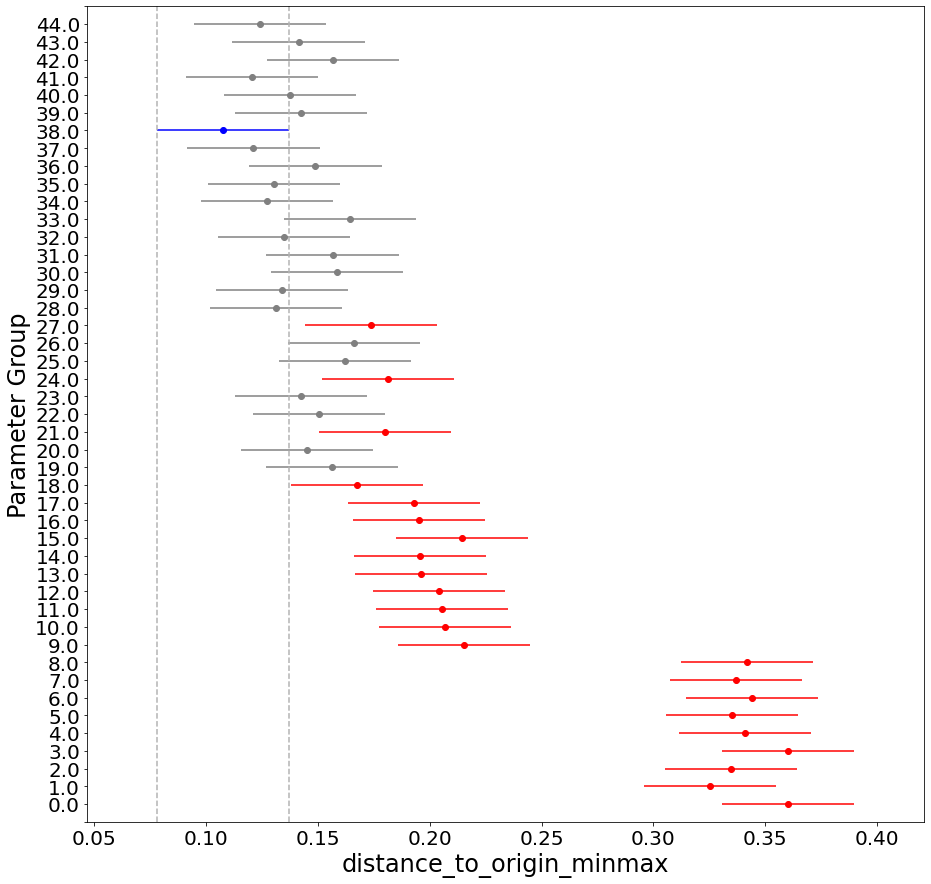

In [155]:
ga_data_tukey,fig,t = anova_plot2(GA_data,'distance_to_origin_minmax','Parameter Group')

# NSGAII

In [190]:
NSGA2_25_2 = pd.read_csv("parameter_data/UK25_2/NSGA2.csv")
NSGA2_25_4 = pd.read_csv("parameter_data/UK25_4/NSGA2.csv")
NSGA2_25_8 = pd.read_csv("parameter_data/UK25_8/NSGA2.csv")
NSGA2_50_1 = pd.read_csv("parameter_data/UK50_1/NSGA2.csv")
NSGA2_75_1 = pd.read_csv("parameter_data/UK75_1/NSGA2.csv")





NSGA2_25_2 = remove_unwanted_mutation_parameter_groups(NSGA2_25_2)
NSGA2_25_2["Parameter Group"] =sorted(list(range(45)) * 30)
combined_NSGA2 = [NSGA2_25_2,NSGA2_25_4,NSGA2_25_8,NSGA2_50_1,NSGA2_75_1]

for df in combined_NSGA2:
    add_final_fitness_columns(df)
    expand_parameter_colums(df)
    add_distance_to_origin(df)
    
    max_fuel_consumption = max(df.fuel_consumption_final)
    min_fuel_consumption = min(df.fuel_consumption_final)
    df["fuel_consumption_final_minmax"] = (df.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption-min_fuel_consumption)
    
    max_distance_to_origin = max(df.distance_to_origin)
    min_distance_to_origin = min(df.distance_to_origin)
    df["distance_to_origin_minmax"] = (df.distance_to_origin - min_distance_to_origin)/(max_distance_to_origin-min_distance_to_origin)
    
    
NSGA2_data = pd.concat(combined_NSGA2)
    

/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



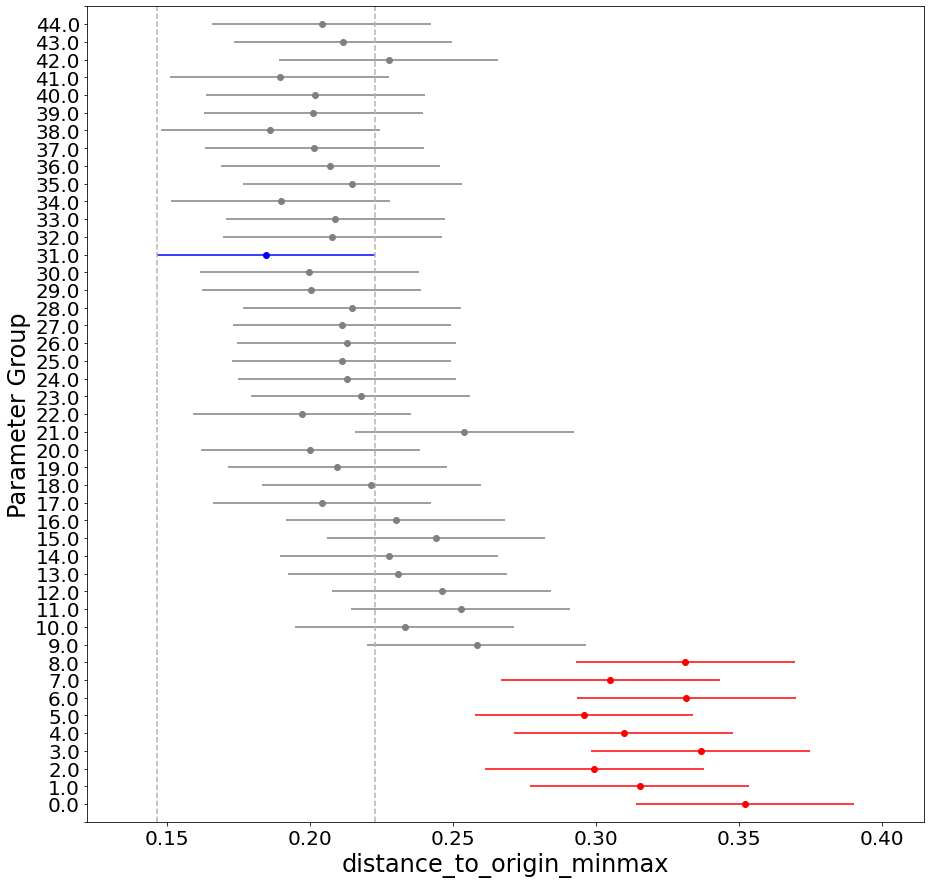

In [191]:
nsga2_data_tukey,fig,t = anova_plot2(NSGA2_data,'distance_to_origin_minmax','Parameter Group')

# NSGAIII

In [178]:
NSGA3_25_2 = pd.read_csv("parameter_data/UK25_2/NSGA3.csv")
NSGA3_25_4 = pd.read_csv("parameter_data/UK25_4/NSGA3.csv")
NSGA3_25_8 = pd.read_csv("parameter_data/UK25_8/NSGA3.csv")
NSGA3_50_1 = pd.read_csv("parameter_data/UK50_1/NSGA3.csv")
NSGA3_75_1 = pd.read_csv("parameter_data/UK75_1/NSGA3.csv")

NSGA3_25_2 = remove_unwanted_mutation_parameter_groups(NSGA3_25_2)
NSGA3_25_2["Parameter Group"] =sorted(list(range(45)) * 30)
combined_NSGA3 = [NSGA3_25_2,NSGA3_25_4,NSGA3_25_8,NSGA3_50_1,NSGA3_75_1]

for df in combined_NSGA3:
    add_final_fitness_columns(df)
    expand_parameter_colums(df)
    add_distance_to_origin(df)
    
    max_fuel_consumption = max(df.fuel_consumption_final)
    min_fuel_consumption = min(df.fuel_consumption_final)
    df["fuel_consumption_final_minmax"] = (df.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption-min_fuel_consumption)
    
    max_distance_to_origin = max(df.distance_to_origin)
    min_distance_to_origin = min(df.distance_to_origin)
    df["distance_to_origin_minmax"] = (df.distance_to_origin - min_distance_to_origin)/(max_distance_to_origin-min_distance_to_origin)
    
    
NSGA3_data = pd.concat(combined_NSGA3)
    

/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



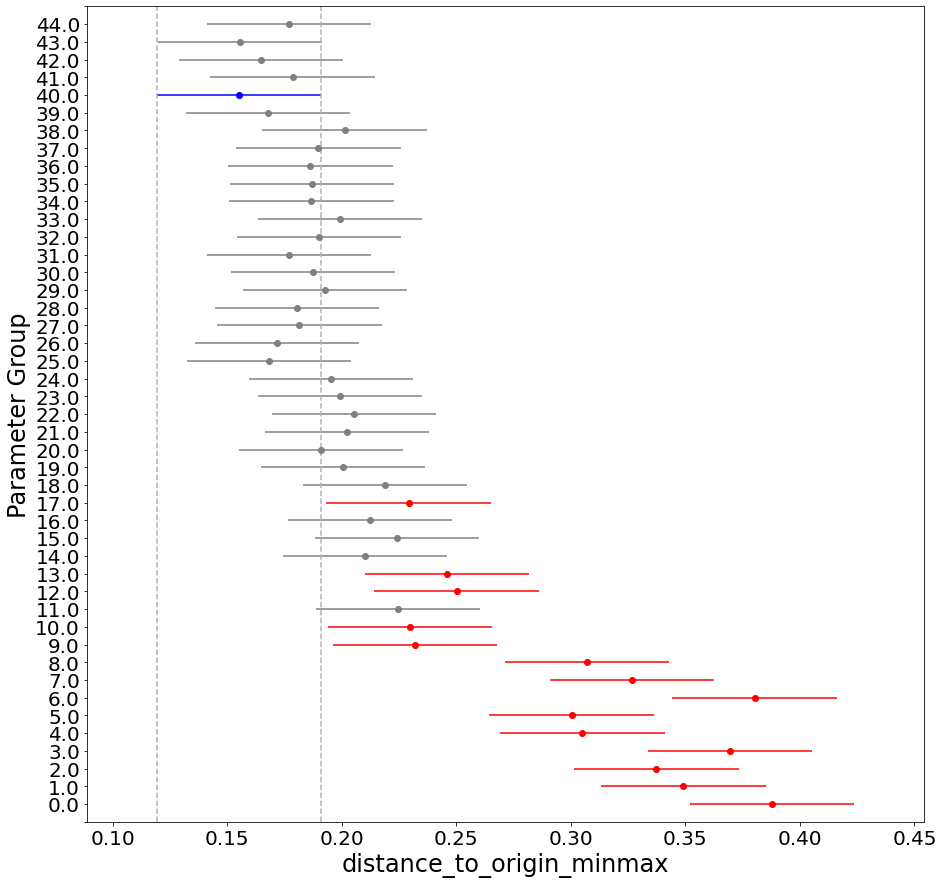

In [194]:
nsga3_data_tukey,fig,t = anova_plot2(NSGA3_data,'distance_to_origin_minmax','Parameter Group')

# UNSGAII

In [180]:
UNSGA3_25_2 = pd.read_csv("parameter_data/UK25_2/UNSGA3.csv")
UNSGA3_25_4 = pd.read_csv("parameter_data/UK25_4/UNSGA3.csv")
UNSGA3_25_8 = pd.read_csv("parameter_data/UK25_8/UNSGA3.csv")
UNSGA3_50_1 = pd.read_csv("parameter_data/UK50_1/UNSGA3.csv")
UNSGA3_75_1 = pd.read_csv("parameter_data/UK75_1/UNSGA3.csv")

UNSGA3_25_2 = remove_unwanted_mutation_parameter_groups(UNSGA3_25_2)
UNSGA3_25_2["Parameter Group"] =sorted(list(range(45)) * 30)
combined_UNSGA3 = [UNSGA3_25_2,UNSGA3_25_4,UNSGA3_25_8,UNSGA3_50_1,UNSGA3_75_1]

for df in combined_UNSGA3:
    add_final_fitness_columns(df)
    expand_parameter_colums(df)
    add_distance_to_origin(df)
    
    max_fuel_consumption = max(df.fuel_consumption_final)
    min_fuel_consumption = min(df.fuel_consumption_final)
    df["fuel_consumption_final_minmax"] = (df.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption-min_fuel_consumption)
    
    max_distance_to_origin = max(df.distance_to_origin)
    min_distance_to_origin = min(df.distance_to_origin)
    df["distance_to_origin_minmax"] = (df.distance_to_origin - min_distance_to_origin)/(max_distance_to_origin-min_distance_to_origin)
    
    
UNSGA3_data = pd.concat(combined_UNSGA3)
    

/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



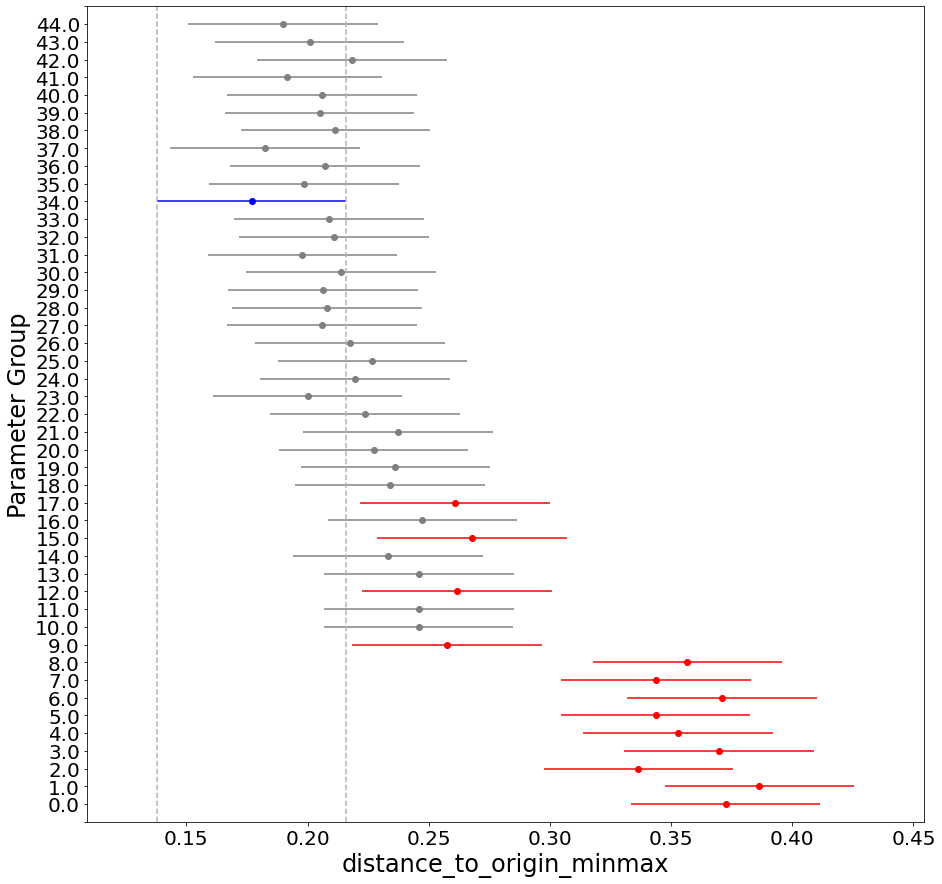

In [181]:
Unsga3_data_tukey,fig,t = anova_plot2(UNSGA3_data,'distance_to_origin_minmax','Parameter Group')

# IBEA

In [188]:
IBEA_25_2 = pd.read_csv("parameter_data/UK25_2/IBEA.csv")
IBEA_25_4 = pd.read_csv("parameter_data/UK25_4/IBEA.csv")
IBEA_25_8 = pd.read_csv("parameter_data/UK25_8/IBEA.csv")
IBEA_50_1 = pd.read_csv("parameter_data/UK50_1/IBEA.csv")
IBEA_75_1 = pd.read_csv("parameter_data/UK75_1/IBEA.csv")
IBEA_75_6 = pd.read_csv("parameter_data/UK75_6/IBEA.csv")

IBEA_25_2 = remove_unwanted_mutation_parameter_groups(IBEA_25_2)
IBEA_25_2["Parameter Group"] =sorted(list(range(45)) * 30)
combined_IBEA = [IBEA_25_2,IBEA_25_4,IBEA_25_8,IBEA_50_1,IBEA_75_1,IBEA_75_6]

for df in combined_IBEA:
    add_final_fitness_columns(df)
    expand_parameter_colums(df)
    add_distance_to_origin(df)
    
    max_fuel_consumption = max(df.fuel_consumption_final)
    min_fuel_consumption = min(df.fuel_consumption_final)
    df["fuel_consumption_final_minmax"] = (df.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption-min_fuel_consumption)
    
    max_distance_to_origin = max(df.distance_to_origin)
    min_distance_to_origin = min(df.distance_to_origin)
    df["distance_to_origin_minmax"] = (df.distance_to_origin - min_distance_to_origin)/(max_distance_to_origin-min_distance_to_origin)
    
    
IBEA_data = pd.concat(combined_IBEA)
    

/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



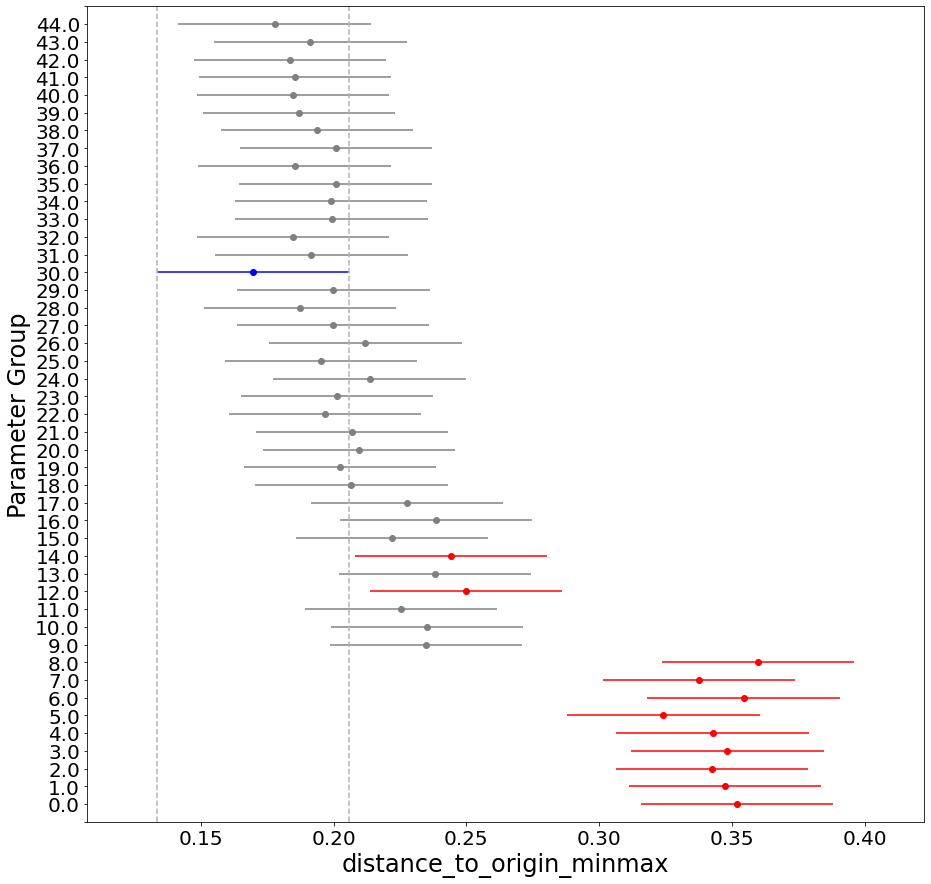

In [189]:
IBEA_data_tukey,fig,t = anova_plot2(IBEA_data,'distance_to_origin_minmax','Parameter Group')